In [1]:
import copy
import os
import sys
import time

import jax
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from helper import df_to_latex, fig_path, set_figsize, tab_path

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


# Import code from src
sys.path.insert(0, '../src/')
import vmc  # noqa

# Set plot and dataframe style
sns.set(context="paper", style='darkgrid', rc={"axes.facecolor": "0.96"})

fontsize = "large"
params = {"font.family": "serif",
          "font.sans-serif": ["Computer Modern"],
          "axes.labelsize": fontsize,
          "legend.fontsize": fontsize,
          "xtick.labelsize": fontsize,
          "ytick.labelsize": fontsize,
          "legend.handlelength": 2
          }

plt.rcParams.update(params)
plt.rc('text', usetex=True)

pd.set_option('display.max_columns', 50)

jax.config.update("jax_enable_x64", True)
jax.config.update('jax_platform_name', 'cpu')

In [2]:
df_rwm = pd.read_csv("../data/sample_ashonib_rwm_all_N.csv")
df_rwm['Algorithm'] = 'RWM'
df_rwm

,chain_id,nparticles,dim,scale,eta,alpha,energy,std_error,variance,scaled_energy,scaled_std_error,scaled_variance,accept_rate,nsamples,total_cycles,tuning_cycles,optimize_cycles,warmup_cycles,Algorithm
0,1,10,3,0.313843,0.01,0.502064,15.000794,0.000782,4.191678e-04,1.500079,0.000782,4.191678e-04,0.254578,65536,120536,9500,45500,0,RWM
1,2,10,3,0.259374,0.01,0.499077,14.999674,0.000376,1.160721e-04,1.499967,0.000376,1.160721e-04,0.366898,65536,119536,7500,46500,0,RWM
2,3,10,3,0.235795,0.01,0.499599,14.999820,0.000192,2.715726e-05,1.499982,0.000192,2.715726e-05,0.413177,65536,115536,6500,43500,0,RWM
3,4,10,3,0.259374,0.01,0.498512,14.999588,0.000705,3.262440e-04,1.499959,0.000705,3.262440e-04,0.355728,65536,113536,9000,39000,0,RWM
4,5,10,3,0.259374,0.01,0.497634,14.997527,0.000943,7.085667e-04,1.499753,0.000943,7.085667e-04,0.360336,65536,115536,7000,43000,0,RWM
5,6,10,3,0.285312,0.01,0.500290,15.000038,0.000119,1.035320e-05,1.500004,0.000119,1.035320e-05,0.304733,65536,123036,7500,50000,0,RWM
6,7,10,3,0.259374,0.01,0.523483,15.036194,0.009603,6.723568e-02,1.503619,0.009603,6.723568e-02,0.338181,65536,85036,7500,12000,0,RWM
7,8,10,3,0.259374,0.01,0.528272,15.025101,0.011650,1.063941e-01,1.502510,0.011650,1.063941e-01,0.339447,65536,85036,7500,12000,0,RWM
8,9,10,3,0.285312,0.01,0.503669,15.002111,0.001661,1.589509e-03,1.500211,0.001661,1.589509e-03,0.305481,65536,109036,8000,35500,0,RWM
9,10,10,3,0.285312,0.01,0.498800,14.999285,0.000470,1.610878e-04,1.499929,0.000470,1.610878e-04,0.302795,65536,120036,7500,47000,0,RWM


In [3]:
df_lmh = pd.read_csv("../data/sample_ashonib_lmh_all_N.csv")
df_lmh['Algorithm'] = 'LMH'
df_lmh

,chain_id,nparticles,dim,dt,eta,alpha,energy,std_error,variance,scaled_energy,scaled_std_error,scaled_variance,accept_rate,nsamples,total_cycles,tuning_cycles,optimize_cycles,warmup_cycles,Algorithm
0,1,10,3,0.885780,0.01,0.493951,15.079684,0.003130,5.199767e-03,1.507968,0.003130,5.199767e-03,0.467957,65536,94036,3500,25000,0,LMH
1,2,10,3,0.732050,0.01,0.498572,15.017165,0.000345,2.302424e-04,1.501717,0.000345,2.302424e-04,0.627335,65536,110036,2500,42000,0,LMH
2,3,10,3,0.605000,0.01,0.499265,15.006797,0.000175,6.533376e-05,1.500680,0.000175,6.533376e-05,0.713318,65536,111536,2000,44000,0,LMH
3,4,10,3,0.605000,0.01,0.502192,14.978617,0.000504,6.279528e-04,1.497862,0.000504,6.279528e-04,0.732620,65536,103036,2000,35500,0,LMH
4,5,10,3,0.732050,0.01,0.500477,14.994515,0.000122,2.569847e-05,1.499451,0.000122,2.569847e-05,0.610535,65536,118036,2500,50000,0,LMH
5,6,10,3,0.885780,0.01,0.500393,14.994867,0.000188,1.948686e-05,1.499487,0.000188,1.948686e-05,0.455719,65536,119536,4000,50000,0,LMH
6,7,10,3,0.732050,0.01,0.500215,14.997601,0.000054,5.400187e-06,1.499760,0.000054,5.400187e-06,0.602921,65536,119036,3500,50000,0,LMH
7,8,10,3,0.885780,0.01,0.503532,14.954342,0.001436,1.600534e-03,1.495434,0.001436,1.600534e-03,0.432861,65536,100536,3500,31500,0,LMH
8,9,10,3,0.885780,0.01,0.498412,15.021696,0.000554,3.027144e-04,1.502170,0.000554,3.027144e-04,0.462097,65536,108536,4000,39000,0,LMH
9,10,10,3,0.732050,0.01,0.500318,14.996353,0.000083,1.221371e-05,1.499635,0.000083,1.221371e-05,0.614777,65536,117036,3500,48000,0,LMH


In [4]:
df = pd.concat([df_rwm, df_lmh], ignore_index=True)
df

,chain_id,nparticles,dim,scale,eta,alpha,energy,std_error,variance,scaled_energy,scaled_std_error,scaled_variance,accept_rate,nsamples,total_cycles,tuning_cycles,optimize_cycles,warmup_cycles,Algorithm,dt
0,1,10,3,0.313843,0.01,0.502064,15.000794,0.000782,0.000419,1.500079,0.000782,0.000419,0.254578,65536,120536,9500,45500,0,RWM,NaN
1,2,10,3,0.259374,0.01,0.499077,14.999674,0.000376,0.000116,1.499967,0.000376,0.000116,0.366898,65536,119536,7500,46500,0,RWM,NaN
2,3,10,3,0.235795,0.01,0.499599,14.999820,0.000192,0.000027,1.499982,0.000192,0.000027,0.413177,65536,115536,6500,43500,0,RWM,NaN
3,4,10,3,0.259374,0.01,0.498512,14.999588,0.000705,0.000326,1.499959,0.000705,0.000326,0.355728,65536,113536,9000,39000,0,RWM,NaN
4,5,10,3,0.259374,0.01,0.497634,14.997527,0.000943,0.000709,1.499753,0.000943,0.000709,0.360336,65536,115536,7000,43000,0,RWM,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,12,100,3,NaN,0.01,0.502064,149.926702,0.006521,0.007303,1.499267,0.006521,0.007303,0.436813,65536,116036,9000,41500,0,LMH,0.407014
92,13,100,3,NaN,0.01,0.501155,149.957749,0.002338,0.002356,1.499577,0.002338,0.002356,0.591431,65536,114036,7000,41500,0,LMH,0.336375
93,14,100,3,NaN,0.01,0.501719,149.919198,0.003976,0.004880,1.499192,0.003976,0.004880,0.472824,65536,118536,10000,43000,0,LMH,0.398914
94,15,100,3,NaN,0.01,0.504645,149.800342,0.011234,0.032567,1.498003,0.011234,0.032567,0.430450,65536,108536,7500,35500,0,LMH,0.407014


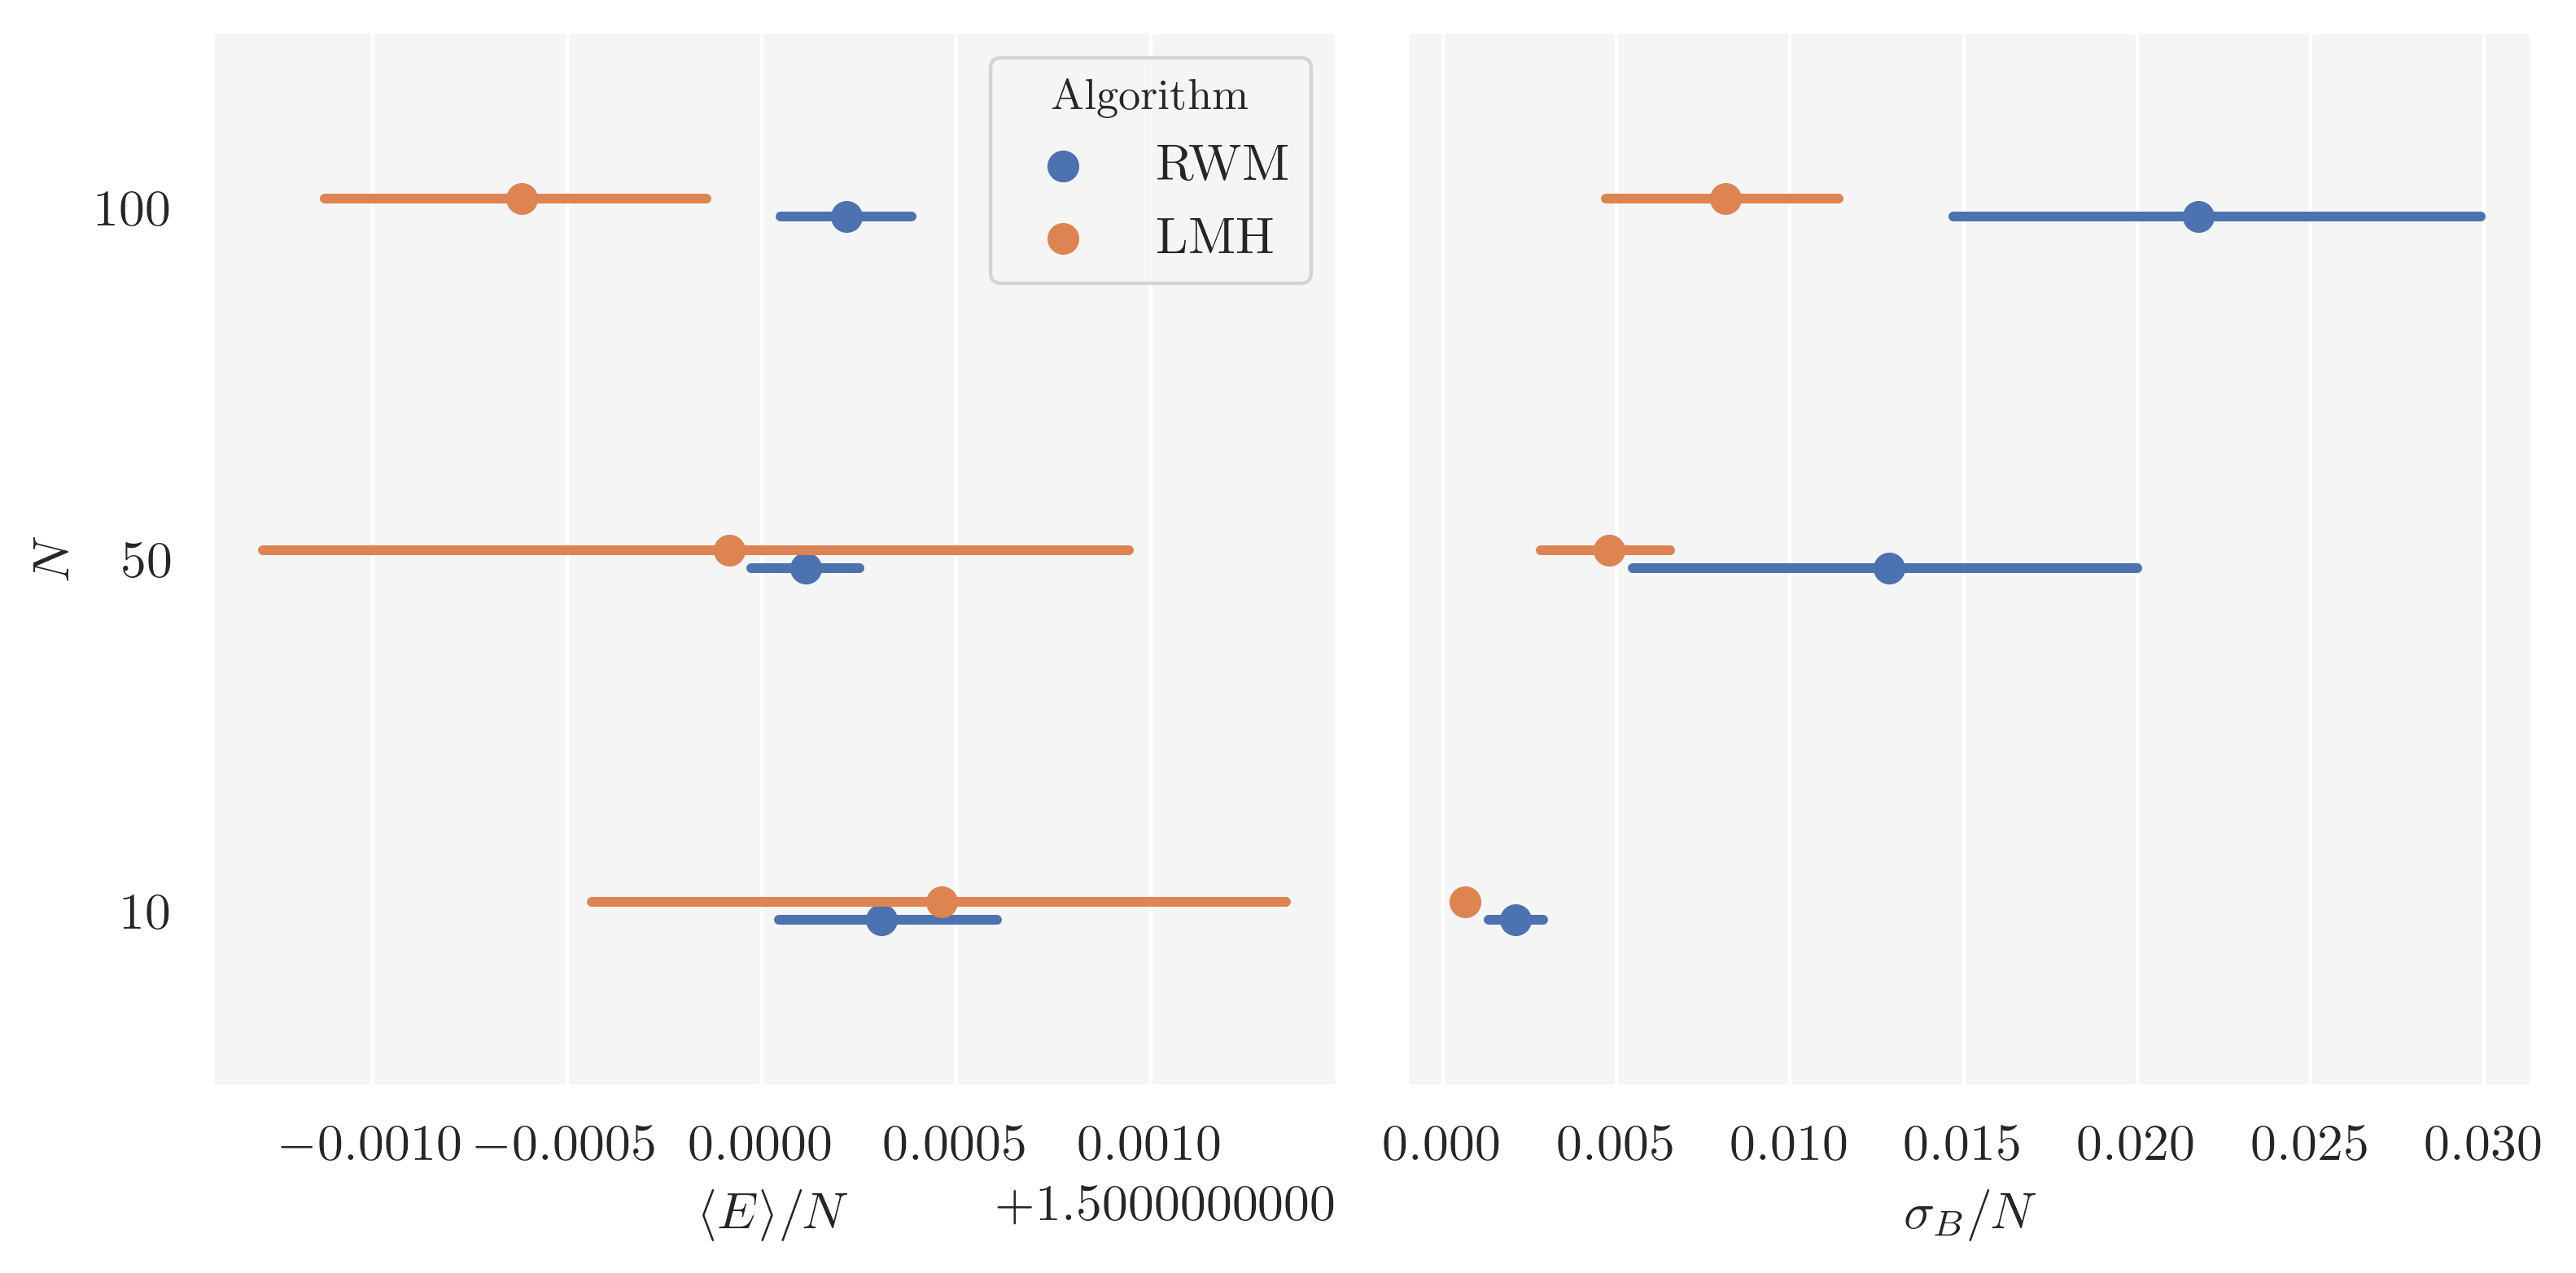

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), sharey=True, tight_layout=True, dpi=200)

sns.pointplot(data=df, 
              x="scaled_energy", 
              y="nparticles", 
              hue="Algorithm",
              join=False,
              dodge=True,
              estimator=np.mean,
              ci=68,
              orient="h",
              ax=axes[0]
             )
axes[0].invert_yaxis()
axes[0].set(xlabel=r'$\langle E \rangle / N$', ylabel=r'$N$')

sns.pointplot(data=df, 
              x="scaled_std_error", 
              y="nparticles", 
              hue="Algorithm",
              join=False,
              dodge=True,
              estimator=np.mean,
              ci=68,
              orient="h",
              ax=axes[1]
             )
axes[1].invert_yaxis()
axes[1].set(xlabel=r'$\sigma_B / N$', ylabel="")
axes[1].legend().set_visible(False)

fig.savefig(fig_path("energy_ashonib.pdf"), bbox_inches='tight')